![Attention Networks](https://www.asimovinstitute.org/wp-content/uploads/2019/04/AN-768x385.png)
# Attending to the Disaster using Transformers 

## Overview
1. Data Preprocessing
    1. Remove Unwanted data from the tweets including urls, user names incorrect words
    2. Remove Stopwords and tokenize using HuggingFace BertWordPiece Tokenizer 
2. Exploratory Analysis 
    1. What a disaster tweet looks like ?
    2. Plot Disaster Tweets most common words by category 
3. Classify Tweets
    1. Use simple pre-trained glove embeddings 
    2. Try BERT (using HuggingFace Implementation)
    3. Try Roberta (using HuggingFace Implementation) 
    4. Tweet Classification models results summary

| ModelName     | Accuracy Reported|
| ------------- |:-------------:|
| Simple Bidirectional Lstm | F1 Score: |
| Bert | F1 Score: |
| Roberta | F1 Score: |

3. Conclusion

In [2]:
!pip install tokenizers
from tokenizers import BertWordPieceTokenizer
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # Regular Expressions
from tqdm import tqdm
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
import tensorflow as tf

from gensim.parsing.preprocessing import remove_stopwords

import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Calculate F1:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val



# List Input Directories
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

C:\Users\SThakur8\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SThakur8\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SThakur8\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SThakur8\AppD

### Data Preprocessing
1.1 Remove Unwanted data from the tweets including urls, user names incorrect words

In [3]:
# Get rid of urls, hashtags, @usernames, emojis via regex
# References: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

# Emojis are a good representation of emotions but for the case of simplicity lets ignore them for now

emoji_pattern = emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
misc_pattern =  re.compile('<.*?>|^http?:\/\/.*[\r\n]*|#|@[^\s]+|http[s]?[^\s]+')
numeric_pattern = re.compile("[0-9]+")
punctuations_pattern = re.compile('[^\w\s]')
# html_pattern '<.*?>'
# url_pattern '^https?:\/\/.*[\r\n]*'
# hash_tags '#'
# username pattern ''@[^\s]+'
# Remove Numbers and complressed urls as such httpssampleurlstoremove using:
# [0-9]+|http[s]?[^\s]+

def clean_tweet(tweet):
    tweet = re.sub(emoji_pattern, '', tweet)
    tweet = re.sub(misc_pattern, '', tweet)
    tweet = re.sub(punctuations_pattern, '', tweet)
    tweet = tweet.lower()
    return remove_stopwords(tweet.strip())

example = " <h1> https://bit.lu/3849yedjk Our Deeds are the Reason @remove_me, of this #earthquake May ALLAH Forgive us all 😔😔, "
print(clean_tweet(example)) # no emoji

deeds reason earthquake allah forgive


In [4]:
# Read and Preprocess the dataset 
train_df = pd.read_csv(r"kaggle/input/train.csv")
test_df = pd.read_csv(r"kaggle/input/test.csv")
print(train_df.shape, test_df.shape)

# Preprocessing 
train_df['text_processed'] = train_df['text'].apply(lambda x: clean_tweet(x))
test_df['text_processed'] = test_df['text'].apply(lambda x: clean_tweet(x))
train_df['keyword'] = train_df['keyword'].apply(lambda x:" ".join(str(x).strip().split("%20")))
test_df['keyword'] = test_df['keyword'].apply(lambda x:" ".join(str(x).strip().split("%20")))

# Looks Like we happen to have a lot of nans in the keywords 
train_df.loc[train_df['keyword']=='nan','keyword'] = np.nan
test_df.loc[train_df['keyword']=='nan','keyword'] = np.nan

# Check class imbalance 
# Looks like is slightly imbalanced, we can solve this issue by sampling accordingly 
print(train_df["target"].value_counts())

# Dropping location as it unavailable for more the 30% dataset in train and 14% in test
train_df.drop("location", axis=1, inplace =True)
test_df.drop("location", axis=1, inplace =True)

# Imputing the missing key words to unknown 
train_df["keyword"].fillna("unknown", inplace=True)

(7613, 5) (3263, 4)
0    4342
1    3271
Name: target, dtype: int64


In [5]:
# Print Data Quality Stats 
train_df.isnull().sum()/train_df.shape[0]*100

id                0.0
keyword           0.0
text              0.0
target            0.0
text_processed    0.0
dtype: float64

In [6]:
test_df.isnull().sum()/train_df.shape[0]*100

id                0.0
keyword           0.0
text              0.0
text_processed    0.0
dtype: float64

In [7]:
# Peeking at the action tweets
list(train_df[['text', 'text_processed',"target"]].sample(n=5).values)

[array(['i wanna get a danger days tattoo so bad how cool would that spider look like on someones wrist or smth',
        'wanna danger days tattoo bad cool spider look like someones wrist smth',
        0], dtype=object),
 array(['FAAN orders evacuation of abandoned aircraft at MMA http://t.co/dEvYbnVXGQ via @todayng',
        'faan orders evacuation abandoned aircraft mma', 0], dtype=object),
 array(['Imagini noi si 2 clipuri The Hobbit: The Desolation of Smaug -... http://t.co/j6CfwUKofE #cliptv #desolationofsmaug #poze #thehobbit',
        'imagini noi si 2 clipuri hobbit desolation smaug cliptv desolationofsmaug poze thehobbit',
        0], dtype=object),
 array(['The Latest: More homes razed by Northern California wildfire - http://t.co/R1CNSjUAYQ http://t.co/DQ1yLcrF9K',
        'latest homes razed northern california wildfire', 1], dtype=object),
 array(['One man fatally shot another wounded on Vermont Street #Buffalo - http://t.co/KakY4mpCO4',
        'man fatally shot wounded

1.2. Remove Stopwords and tokenize using HuggingFace BertWordPiece Tokenizer 

In [8]:
# Train a custom BertWordPieceTokenizer which takes into account most of the tokens due to word piece stratergy
# minimizing number of unknowns
from tokenizers import trainers
processed_txt = train_df['text_processed'].to_list()
with open("kaggle/output/train_text.txt", "w+", encoding="utf-8") as f:
    f.writelines(processed_txt)
tokenizer = BertWordPieceTokenizer(lowercase=True)
tokenizer.train([
	"kaggle/output/train_text.txt"
])

 3. What a disaster tweet looks like ?

Max Tweet length  138
Tokenized Example:  ['deeds', 'reason', 'earthquake', 'allah', 'forg', '##ive', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

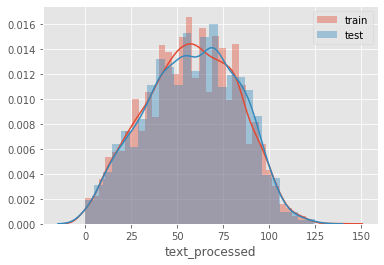

In [9]:
# Word Count Distributions 
sns.distplot(train_df['text_processed'].apply(lambda x:len(x)), label='train')
sns.distplot(test_df['text_processed'].apply(lambda x:len(x)), label = 'test')
plt.legend()
# This helps to set our max tweet length to 150
MAX_TWEET_LEN = train_df['text_processed'].apply(lambda x: len(x)).max() 
print("Max Tweet length ", MAX_TWEET_LEN)
# Enable Padding and Truncation at Max Length 
tokenizer.enable_padding(max_length=MAX_TWEET_LEN)
tokenizer.enable_truncation(max_length=MAX_TWEET_LEN)
print("Tokenized Example: ", tokenizer.encode(clean_tweet(example)).tokens)
print("Vocab Size: ", tokenizer.get_vocab_size())

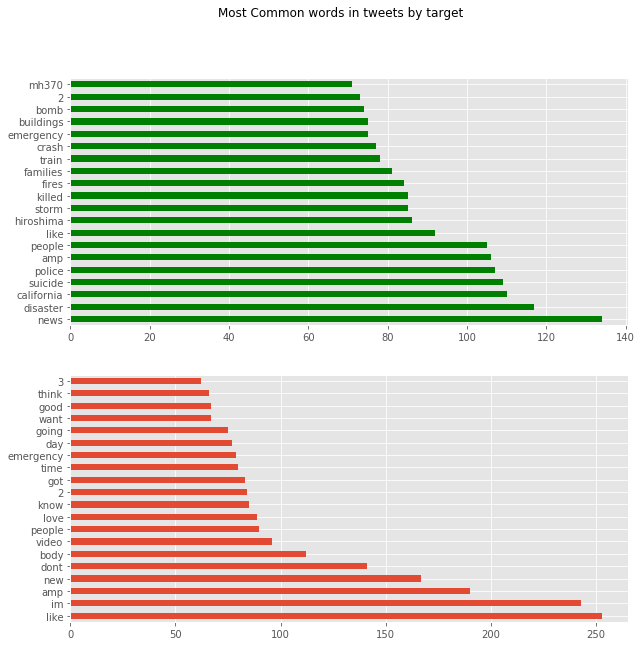

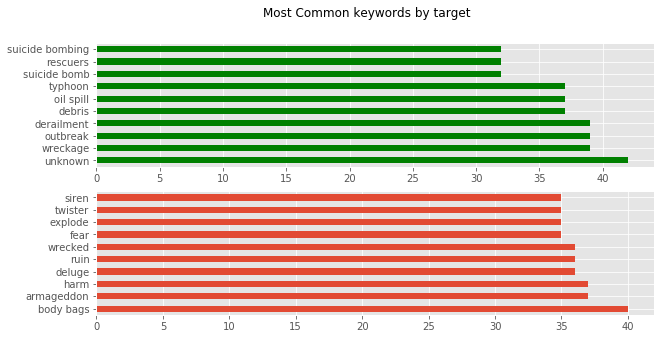

In [10]:
# Most common words in the dataset 
disaster_tweet_words = [word for i in train_df.loc[train_df['target'] ==1, 'text_processed'].apply(lambda x:x.split()).to_list() for word in i]
normal_tweet_words = [word for i in train_df.loc[train_df['target'] == 0, 'text_processed'].apply(lambda x:x.split()).to_list() for word in i]
disaster_tweet_words_df = pd.Series(disaster_tweet_words)
normal_tweet_words_df = pd.Series(normal_tweet_words)

# Top Most common keywords
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10))
disaster_tweet_words_df.value_counts()[:20].plot(kind='barh', ax = ax1, color = 'green')
normal_tweet_words_df.value_counts()[:20].plot(kind='barh', ax = ax2)
fig.suptitle("Most Common words in tweets by target")
# Top Most common keywords
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,5))
# Keywords by Target 
train_df[train_df['target'] == 1]['keyword'].value_counts()[:10].plot(kind='barh', ax = ax1, color = 'green')
train_df[train_df['target'] == 0]['keyword'].value_counts()[:10].plot(kind='barh', ax = ax2)
fig.suptitle("Most Common keywords by target")
#Hack: Instead of using keywords as a separate feature, lets add it towards the end of our tweets 
train_df['text_processed'] = train_df['text_processed'] + " " + train_df['keyword']
test_df['text_processed'] = test_df['text_processed'] + " " + test_df['keyword']

3.1. Use simple pre-trained glove embeddings 

#### GloVe Word Embeddings
* GloVe is essentially a log-bilinear model with a weighted least-squares objective. The main intuition underlying the model is the simple observation that ratios of word-word co-occurrence probabilities have the potential for encoding some form of meaning. 
* We will make use of 200 dimension pre-trained embeddings trained on twitter dataset
* [Twitter Embeddings](https://www.kaggle.com/fullmetal26/glovetwitter27b100dtxt#glove.twitter.27B.200d.txt) available on Kaggle

In [12]:
# Lets Tokenize out train and test data 
# Define Out of Vocaboulary token 
# oov_token = "UNK"
EMBEDDING_DIM = 200
train_texts = train_df['text_processed'].to_list()
test_texts = test_df['text_processed'].to_list()


#Note: Fit the Keras Pre - Processing tokenizer only on Train and not on Test 
# for obvious reasons :p
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Transform text to sequences 
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences =pad_sequences(train_sequences, maxlen=MAX_TWEET_LEN ,truncating='post',padding='post')

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences =pad_sequences(test_sequences, maxlen=MAX_TWEET_LEN ,truncating='post',padding='post')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Create Embedding Matrix from Glove Words and Tokenizer Vocabulary
def make_embedding_index(embedding_file_path):
    embeddings_index = dict()
    f = open(embedding_file_path, encoding='utf-8')
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word.replace("<","").replace(">","")] = coefs
    f.close()
    return embeddings_index

embeddings_index = make_embedding_index(r'kaggle/input/glove.twitter.27B.200d.txt')
# embeddings_index = make_embedding_index('/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt')

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
oov_tokens = []
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        oov_tokens.append(word)

print("Total Out of Vocabulary Words:",len(oov_tokens))

# Reference: https://keras.io/examples/pretrained_word_embeddings/
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = tf.keras.layers.Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_TWEET_LEN,trainable=False)

1193514it [01:50, 10774.43it/s]


Found 15537 unique tokens.
Total Out of Vocabulary Words: 3546


3.1. Start with Lstms to establish a baseline 
#### Simple Bidirectional Lstms models 

In [13]:
# Got 0.76 in terms of accuracy on leader board https://www.kaggle.com/thakursc1/attending-to-disaster?scriptVersionId=29243878  

# TODO: Changing model , adding residuals... WORK IN PROGRESS 

print('Training a LSTM model...')
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = optimizers.Adam(lr = 1e-3)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', 'Precision', 'Recall', f1_score]
)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]
model.summary()

print(train_sequences.shape)
labels = train_df['target'].to_numpy().reshape(-1)
# Training on Kaggle Kernels with GPU 
model.fit(train_sequences, labels, )

history = model.fit(
    train_sequences, 
    labels,
validation_split=0.2,
          batch_size=128, epochs=3, verbose=1, callbacks = callbacks
)

Training a LSTM model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 138, 200)          3107600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 138, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 138, 512)          935936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 138, 256)          656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 138, 128)          164352    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 138, 64)           41216     
_________________________________________________________________
bidirectional_4 (Bidirection (N

W0505 00:26:32.582288 25584 callbacks.py:1934] Reduce LR on plateau conditioned on metric `loss` which is not available. Available metrics are: lr
W0505 00:26:32.582288 25584 callbacks.py:1286] Early stopping conditioned on metric `loss` which is not available. Available metrics are: 


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/bidirectional_2/forward_lstm_2/while/body/_1077/strided_slice_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics/Recall/assert_greater_equal/Assert/AssertGuard/pivot_f/_5930/_105]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/bidirectional_2/forward_lstm_2/while/body/_1077/strided_slice_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_33259]

Function call stack:
distributed_function -> distributed_function


In [ ]:
test_df['probs']  = model.predict(test_sequences)
test_df['target'] = (test_df['probs'] > 0.5).astype(int)
test_df[['id', 'target']].to_csv('submission.csv', index=False)

2. Try BERT (using HuggingFace Implementation)
![BERT](http://www.mccormickml.com/assets/BERT/padding_and_mask.png)
pic credits: [https://mccormickml.com/](https://mccormickml.com/) 

In [ ]:
from transformers import TFBertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.


train_size = int(0.9 * (train_df.shape[0]))
val_size = train_df.shape[0] - train_size

# Training Data
train_dataset = tokenizer.batch_encode_plus(
    train_df.iloc[:train_size]['text_processed'].values,
    add_special_tokens=True,
    max_length=MAX_TWEET_LEN,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='tf'
)
train_labels = train_df.iloc[:train_size]['target'].values.reshape((-1, 1))

# Validation Data
val_dataset = tokenizer.batch_encode_plus(
    train_df.iloc[train_size:]['text_processed'].values,
    add_special_tokens=True,
    max_length=MAX_TWEET_LEN,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='tf'
)
val_labels = train_df.iloc[train_size:]['target'].values.reshape((-1, 1))

# Testing Data for making predictions
test_dataset = tokenizer.batch_encode_plus(
    test_df['text_processed'].values,
    add_special_tokens=True,
    max_length=MAX_TWEET_LEN,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='tf'
)


def create_model():
    bert_model = TFBertForSequenceClassification.from_pretrained(
        "bert-base-uncased")

    input_ids = tf.keras.layers.Input((MAX_TWEET_LEN,), dtype=tf.int32, name='input_ids')
    token_type_ids = tf.keras.layers.Input((MAX_TWEET_LEN,), dtype=tf.int32, name='token_type_ids')
    attention_mask = tf.keras.layers.Input((MAX_TWEET_LEN,), dtype=tf.int32, name='attention_mask')

    # Use pooled_output(hidden states of [CLS]) as sentence level embedding
    pooled_output = \
        bert_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})[0]
    x = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(
        inputs={'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}, outputs=x)
    return model


EPOCHS = 2
BATCH_SIZE = 2
model = create_model()

print(model.summary())

# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['Precision', 'Recall', f1_score])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(
    x=train_dataset,
    y=train_labels,
    validation_data=(val_dataset, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Load the TensorFlow model in PyTorch for inspection
model.save_pretrained('./save/')

from sklearn.metrics import classification_report

test_df['probs'] = model.predict(test_dataset)
test_df['target'] = (test_df['probs'] > 0.5).astype(int)
test_df[['id', 'target']].to_csv('BertSubmission.csv', index=False)
print(classification_report(test_df['probs'], test_df['']))